`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (проверка по блокам)

*Модели*: множественная линейная регрессия 
*Данные*: `Auto_for_lab` (источник: <https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv>)

# Указания к выполнению


## Загружаем пакеты

In [58]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [59]:
# константы
#  ядро для генератора случайных чисел
my_seed = 6
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `Auto_for_lab` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [60]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (392, 10)


In [61]:
# первые 5 строк фрейма
DF_raw.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,cyl_over_4
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,1
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,1
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,1
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,1
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,1



* **mpg**- мили на галлон;
* **cylinders**– количество цилиндров;
* **displacement**– объем двигателя;
* **horsepower**– количество лошадиных сил;
* **weight**– вес автомобиля;
* **acceleration**– разгон;
* **year**– от 70 до 82;
* **origin**– континент производства.
* **name**– название автомобиля.
* **cyl_over_4**– количество цилиндров больше 4(0-нет;1-да).

In [62]:
# типы столбцов фрейма
DF_raw.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
cyl_over_4        int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [63]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
cyl_over_4      0
dtype: int64

Пропусков не обнаружено.  

In [64]:
# оставляем в наборе данных только то, что нужно 
DF_raw = DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]
DF_raw.columns

Index(['mpg', 'displacement', 'acceleration', 'cyl_over_4'], dtype='object')

In [65]:
DF_raw.dtypes

mpg             float64
displacement    float64
acceleration    float64
cyl_over_4        int64
dtype: object

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [66]:
# данные для построения моделей
DF = DF_raw.sample(frac=0.8, random_state=my_seed)
# данные для прогнозов
DF_predict = DF_raw.drop(DF.index)


## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `mpg`, которая является зависимой переменной модели, сильно отличается по масштабу от всех остальных.    Также заметим, что из всех объясняющих только переменная `mpg` принимает нулевые значения. Остальные показатели положительны.  

In [67]:
# описательные статистики для непрерывных переменных
DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']].describe()

,mpg,displacement,acceleration,cyl_over_4
count,392.000000,392.000000,392.000000,392.000000
mean,23.445918,194.411990,15.541327,0.482143
std,7.805007,104.644004,2.758864,0.500320
min,9.000000,68.000000,8.000000,0.000000
25%,17.000000,105.000000,13.775000,0.000000
50%,22.750000,151.000000,15.500000,0.000000
75%,29.000000,275.750000,17.025000,1.000000
max,46.600000,455.000000,24.800000,1.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

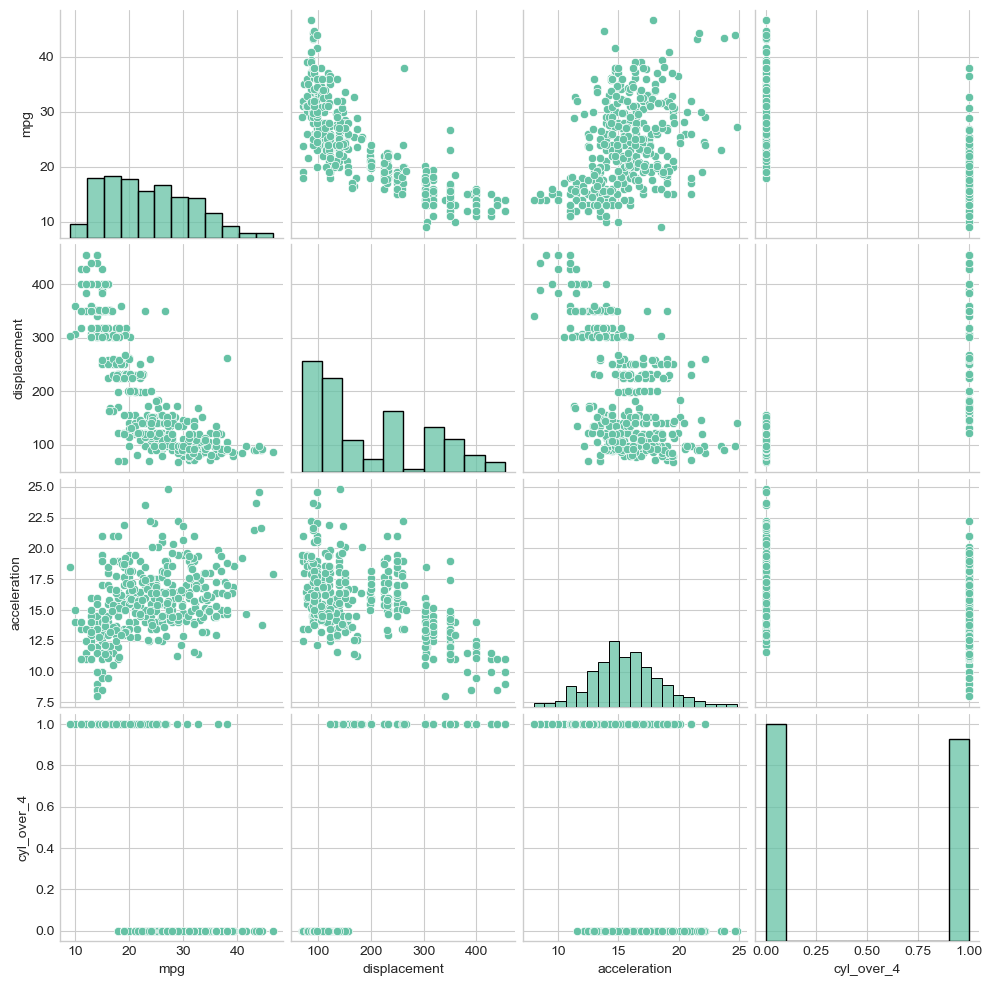

In [68]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF_all[['mpg', 'displacement', 'acceleration', 'cyl_over_4']])
plt.show()

Судя по этим графикам:  
* распределение зависимой `mpg` не является нормальным;  
* из всех объясняющих нормально распределена только `acceleration`;  
* имеется четыре уровня разгона, что заметно на графиках разброса `displacement`, `acceleration`;  
* объясняющая `cyl_over_4` дискретна, что очевидно из её смысла: ;  
* разброс значений `displacement` у автомобилей с количеством цилиндров 4 и меньше (максимум из таблицы выше) намного меньше, чем у остальных автомобилей.  

Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из фиктивных объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от mpg.  

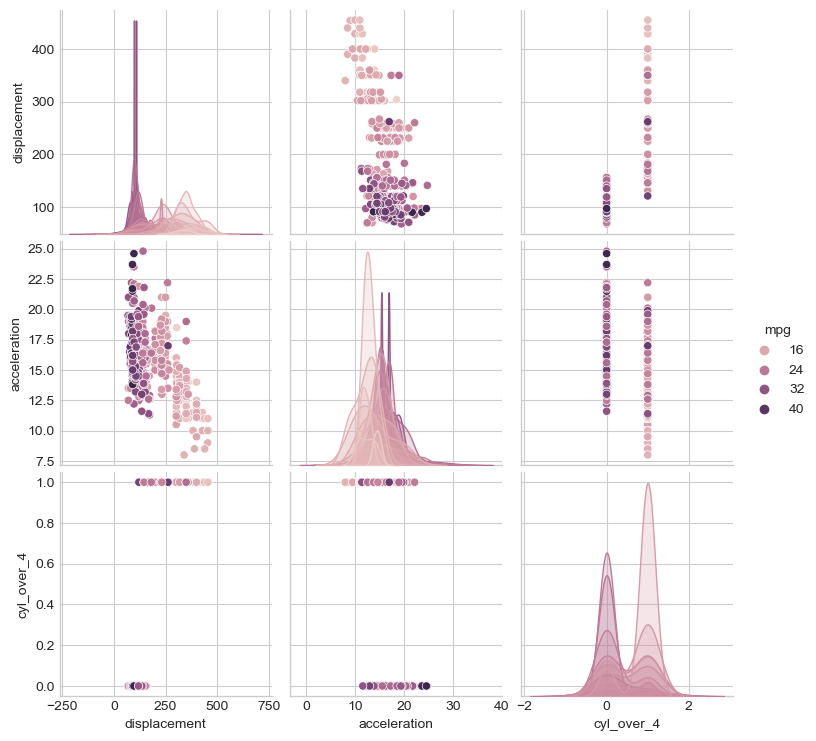

In [70]:
# матричный график разброса с цветом по mpg
sns.pairplot(DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']],
            hue='mpg')

plt.show()

Теперь покажем цветом на графиках отношение автомобилей от количества цилиндров больше 4.

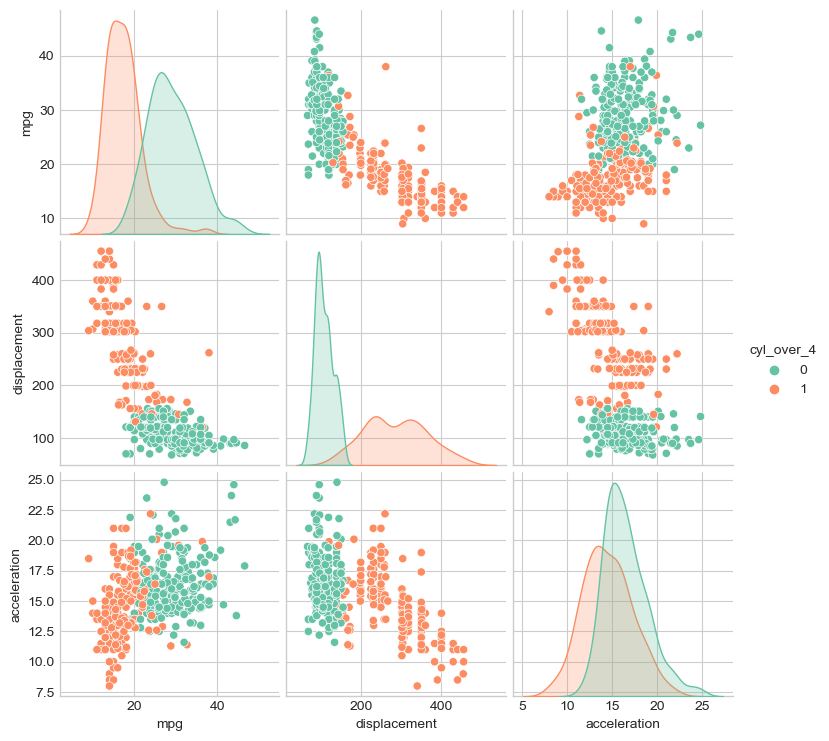

In [71]:
# матричный график разброса с цветом по cyl_over_4
sns.pairplot(DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']],
            hue='cyl_over_4')

plt.show()

Покажем с помощью цвета на графиках объема двигателя.

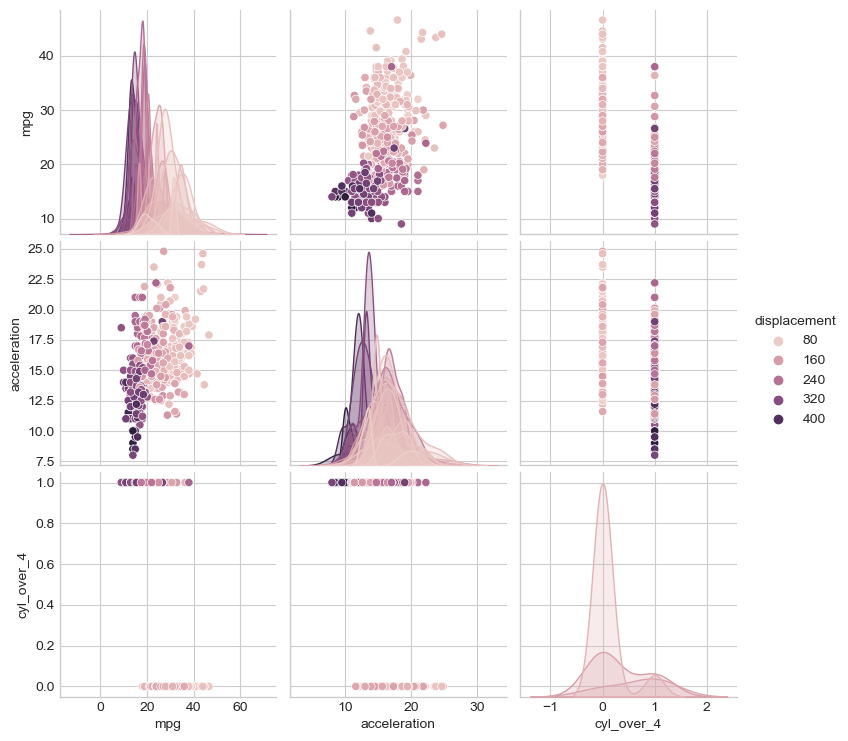

In [72]:
# матричный график разброса с цветом по region
sns.pairplot(DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']], hue='displacement')
plt.show()

Нарисуем график отдельно по `acceleration`.  

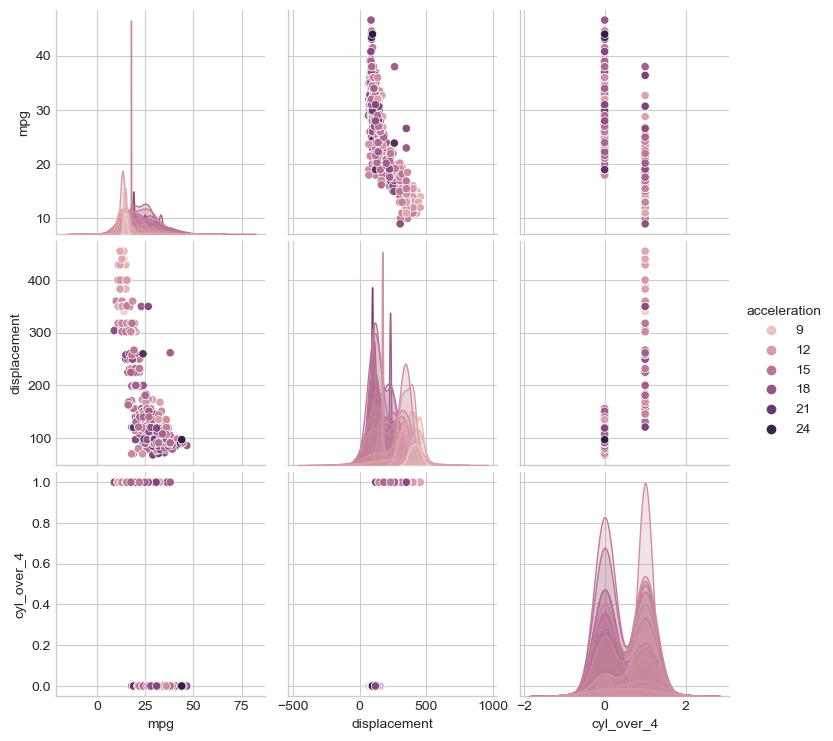

In [73]:
# матричный график разброса с цветом по разгону
sns.pairplot(DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']], hue='acceleration')
plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [74]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\Credu\AppData\Local\Temp\ipykernel_2908\1793619055.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,mpg,displacement,acceleration,cyl_over_4
mpg,1.00,-0.81,0.42,-0.75
displacement,-0.81,1.00,-0.54,0.85
acceleration,0.42,-0.54,1.00,-0.37
cyl_over_4,-0.75,0.85,-0.37,1.00


Посчитаем корреляционные матрицы для количество цилиндров больше 4 и меньше.  

In [75]:
# корреляционная матрица по классу количество цилиндров больше 4
corr_mat = DF_raw.loc[DF_raw['cyl_over_4'] == 1][['mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,mpg,displacement,acceleration
mpg,1.000000,-0.675662,0.400239
displacement,-0.675662,1.000000,-0.630885
acceleration,0.400239,-0.630885,1.000000


In [76]:
# корреляционная матрица по классу количество цилиндров  4 и меньше
corr_mat = DF_raw.loc[DF_raw['cyl_over_4'] == 0][['mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,mpg,displacement,acceleration
mpg,1.000000,-0.410898,0.120019
displacement,-0.410898,1.000000,-0.129488
acceleration,0.120019,-0.129488,1.000000




### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [77]:
# логарифмируем зависимую переменную
DF_raw['log_mpg'] = np.log(DF_raw['mpg'])
# описательные статистики для непрерывных показателей
DF_raw[['mpg','log_mpg', 'displacement', 'acceleration', 'cyl_over_4']].describe()


,mpg,log_mpg,displacement,acceleration,cyl_over_4
count,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,3.098313,194.411990,15.541327,0.482143
std,7.805007,0.340039,104.644004,2.758864,0.500320
min,9.000000,2.197225,68.000000,8.000000,0.000000
25%,17.000000,2.833213,105.000000,13.775000,0.000000
50%,22.750000,3.124505,151.000000,15.500000,0.000000
75%,29.000000,3.367296,275.750000,17.025000,1.000000
max,46.600000,3.841601,455.000000,24.800000,1.000000


Проведём формальные тесты на нормальность.  

In [78]:
# тестируем на нормальность
for col in ['mpg', 'log_mpg']:
    stat, p = shapiro(DF_raw[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

mpg Statistics=0.97, p=0.0000
Распределение не нормально (H0 отклоняется)

log_mpg Statistics=0.98, p=0.0001
Распределение не нормально (H0 отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

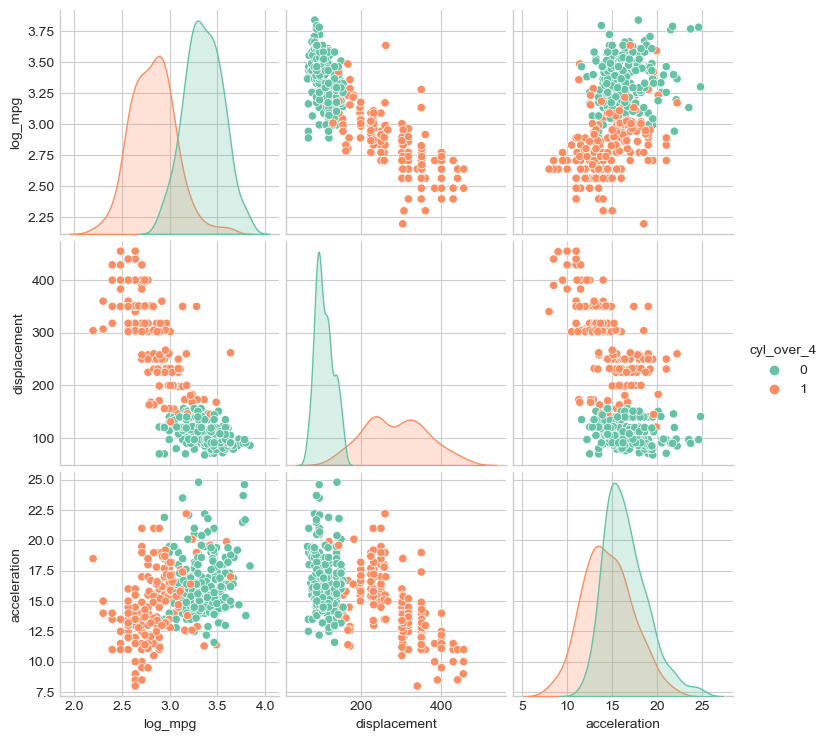

In [79]:
# матричный график разброса с цветом по cyl_over_4
sns.pairplot(DF_raw[['log_mpg', 'displacement', 'acceleration', 'cyl_over_4']], hue='cyl_over_4')
plt.show()

In [83]:
# корреляционная матрица по классу не курильщиков
corr_mat = DF_raw.loc[DF_raw['cyl_over_4'] == 0][['log_mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,log_mpg,displacement,acceleration
log_mpg,1.000000,-0.399972,0.101899
displacement,-0.399972,1.000000,-0.129488
acceleration,0.101899,-0.129488,1.000000


In [82]:
# корреляционная матрица по классу цилиндров больше 4
corr_mat = DF_raw.loc[DF_raw['cyl_over_4'] == 1][['log_mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat


,log_mpg,displacement,acceleration
log_mpg,1.000000,-0.709259,0.417245
displacement,-0.709259,1.000000,-0.630885
acceleration,0.417245,-0.630885,1.000000


## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot displacement + \hat{\beta_3} \cdot acceleration$
1. `fit_lm_2`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot displacement \cdot cyl\_over\_4 + \hat{\beta_3} \cdot acceleration$
1. `fit_lm_3`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot acceleration \cdot cyl\_over\_4 + \hat{\beta_3} \cdot displacement$
1. `fit_lm_4`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot acceleration \cdot cyl\_over\_4 + \hat{\beta_3} \cdot displacement \cdot cyl\_over\_4$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_mpg}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_mpg}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_mpg}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_mpg}$

Кроме того, добавим в сравнение модели зависимости `mpg` и `log_mpg` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно.  


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [84]:
# данные для моделей 1, 5
df1 = DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]

# данные для моделей 2, 6
df2 = DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]
df2.loc[:, 'displacement_cyl_over_4'] = df2.loc[:, 'displacement'] * df2.loc[:, 'cyl_over_4']
df2 = df2.drop(['displacement'], axis=1)

# данные для моделей 3, 7
df3 = DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]
df3.loc[:, 'acceleration_cyl_over_4'] = df3.loc[:, 'acceleration'] * df3.loc[:, 'cyl_over_4']
df3 = df3.drop(['acceleration'], axis=1)

# данные для моделей 4, 8
df4 = DF_raw[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]
df4.loc[:, 'displacement_cyl_over_4'] = df4.loc[:, 'displacement'] * df4.loc[:, 'cyl_over_4']
df4.loc[:, 'acceleration_cyl_over_4'] = df4.loc[:, 'acceleration'] * df4.loc[:, 'cyl_over_4']
df4 = df4.drop(['acceleration', 'displacement'], axis=1)

# данные для моделей 9, 10
df0 = DF_raw.drop(['log_mpg'], axis=1)

In [85]:
# проверка результатов
df4.head()


,mpg,cyl_over_4,displacement_cyl_over_4,acceleration_cyl_over_4
0,18.0,1,307.0,12.0
1,15.0,1,350.0,11.5
2,18.0,1,318.0,11.0
3,16.0,1,304.0,12.0
4,17.0,1,302.0,10.5


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `mpg` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [86]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['mpg'], axis=1)
y = df0.mpg.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))


модель fit_lm_0:
 константа  [33.188] 
 объясняющие  ['displacement', 'acceleration', 'cyl_over_4'] 
 коэффициенты  [[-0.043  0.039 -3.998]]


In [87]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([4.50364779])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [88]:
# модель со всеми объясняющими, y_log
X = df0.drop(['mpg'], axis=1)
y = np.log(df0.mpg).values.reshape(-1, 1)

fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.599] 
 объясняющие  ['displacement', 'acceleration', 'cyl_over_4'] 
 коэффициенты  [[-0.002  0.    -0.122]]


In [89]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ -0.2,   0. , -11.5]])

In [90]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([4.43035971])

In [91]:
print('MSE_train модели для mpg меньше MSE_train',
     'модели для log(mpg) в ', np.around(MSE_log / MSE, 4), 'раз')

MSE_train модели для mpg меньше MSE_train модели для log(mpg) в  [0.9677] раз


### Оценка точности

#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [92]:
# Перекрёстная проверка по 5 блокам
folds = 5

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 5)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['mpg'], axis=1)
    y = df.mpg
    kf_5 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_5,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 5 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 5 блокам заняли 0.16 секунд


In [93]:
# Перекрёстная проверка по 10 блокам
folds = 5

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 5)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['mpg'], axis=1)
    y = np.log(df.mpg)
    kf_5 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_5,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 5 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 5 блокам заняли 0.15 секунд


In [94]:
scores

[-21.31693227043677,
 -20.816006755353836,
 -22.367389480553292,
 -20.654635318730403,
 -22.67674457257945]

In [95]:
# самая точная на mpg
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold5 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf5 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold5 у модели fit_lm_3 :
MSE_kf5 = 21.0


In [96]:
# самая точная на log(mpg)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold5 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf5 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold5 у модели fit_lm_1_log :
MSE_kf5 = 0.031


Самой точной среди моделей для `mpg` оказалась `fit_lm_1`, а среди моделей для `mpg_log` – `fit_lm_1_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [102]:
# прогноз по fit_lm_3
#  модель на всех обучающих наблюдениях
X = df1.drop(['mpg'], axis=1)
y = df1.mpg.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['mpg']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['mpg'], axis=1)
#  прогнозы
y_pred = fit_lm_3.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_3 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_3 на отложенных наблюдениях = 30.29


In [105]:
# прогноз по fit_lm_log_0
# модель
X = df0.drop(['mpg'], axis=1)
y = np.log(df0.mpg).values.reshape(-1, 1)
fit_lm_1_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['mpg']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['mpg'], axis=1)

#  прогнозы
y_pred = fit_lm_1_log.predict(X)
# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_1_log на отложенных наблюдениях = 30.76


In [106]:
np.sqrt(MSE_log) / np.mean(DF_predict[['mpg']]) * 100

D:\anaconda3\envs\env02\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


mpg    22.810862
dtype: float64

In [107]:
np.sqrt(MSE) / np.mean(DF_predict[['mpg']]) * 100

D:\anaconda3\envs\env02\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


mpg    22.634131
dtype: float64

Очевидно, на выборке для прогноза точнее модель `fit_lm_3`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot acceleration \cdot cyl\_over\_4 + \hat{\beta_3} \cdot displacement$

In [108]:
X = df3.drop(['mpg'], axis=1)
y = df3.mpg.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)

print('модель fit_lm_3:\n', 
      'константа ', np.around(fit_lm_3.intercept_, 3),
      '\n объясняющие ', list(df3.drop(['mpg'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_3.coef_, 3))

модель fit_lm_3:
 константа  [34.419] 
 объясняющие  ['displacement', 'cyl_over_4', 'acceleration_cyl_over_4'] 
 коэффициенты  [[-0.049  0.093 -0.221]]


# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  